In [5]:
import emcee
import george 
import corner 
import numpy as np 
import matplotlib.pyplot as plt 
from george import kernels 
from george.modeling import Model


In [17]:
# Consider the following simulated data that mimicks a planetary transit event 

class Model(Model):
    parameter_names = ("amp","location","log_sigma2")

    def get_value(self,t):
        return self.amp*np.exp(-0.5*(t.flatten()-self.location)**2 * np.exp(-self.log_sigma2))
    


def generate_data(params, N, rng=(-5, 5)):
    gp = george.GP(0.1 * kernels.ExpSquaredKernel(3))
    t = rng[0] + (rng[1] - rng[0]) * np.sort(np.random.rand(N))  
    y = gp.sample(t)
    y += Model(**params).get_value(t)
    # Adding observation noise
    yerr = 0.05 + 0.05 * np.random.rand(N)
    y += yerr * np.random.randn(N)
    # Retrieving covariance matrix
    cov = gp.get_matrix(t) + np.diag(yerr**2)
    return t, y, yerr, cov

# Define truth and run the simulation
truth = dict(amp=-1.0, location=0.1, log_sigma2=np.log(0.4))
true_model = Model(**truth)

# Generate data
t, y, yerr, cov = generate_data(truth, 50)


 


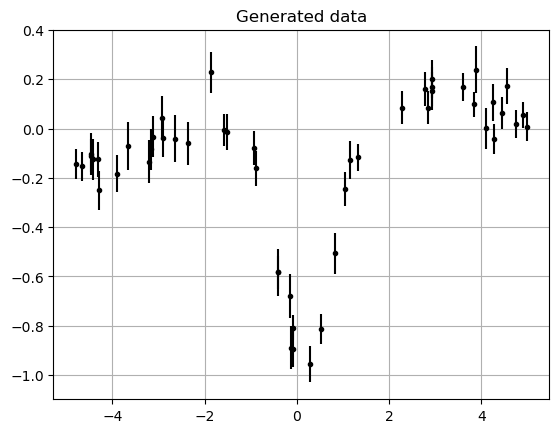

In [20]:
plt.errorbar(t,y,yerr=yerr,fmt = ".k",capsize=0)
plt.title("Generated data")
plt.grid()

In [21]:
# we bouild the followiung model 

def model1(params,t): 
    m,b,amp,loc, lnsig2 = params 
    return m*t + b + amp*np.exp(-0.5*(t-loc)**2 * np.exp(-lnsig2))

In [22]:
# We are going to assume a Gaussian likelihood with diagonal covariance, set 
# by the measurement errors
def lnlike1(p, t, y, yerr):
    return -0.5 * np.sum(((y - model1(p, t))/yerr) ** 2)

In [23]:
def lnprior1(p):
    m, b, amp, loc, lnsig2 = p
    if (-1 < m < 1 and  -1 < b < 1 and -10 < amp < 10 and
            -5 < loc < 5 and  -2< lnsig2 < 1):
       
        return 0.0
    return -np.inf


def lnprob1(p, x, y, yerr):
    lp = lnprior1(p)
    return lp + lnlike1(p, x, y, yerr) if np.isfinite(lp) else -np.inf

In [24]:
import emcee
nwalkers=32
initial = np.array([0, 0, -1.0, 0.1, 0.])
ndim = len(initial)
p0 = [np.array(initial) + 1e-8 * np.random.randn(ndim)
      for i in range(nwalkers)]
data=(t, y, yerr)

# Call emcee with function that returns the log posterior
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob1, args=data)

print("Running burn-in...")
p0, _, _ = sampler.run_mcmc(p0, 500)
sampler.reset()

print("Running production...")
s = sampler.run_mcmc(p0, 1000)

Running burn-in...
Running production...


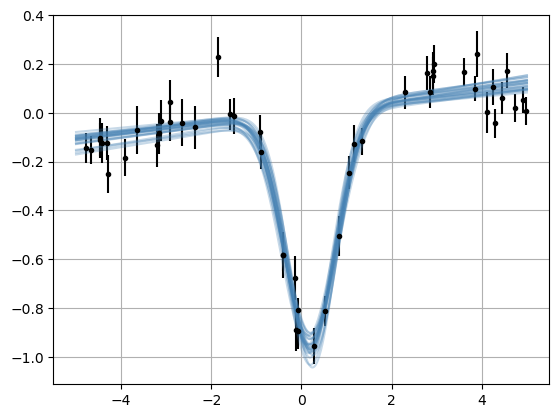

In [28]:
# Plot the data.
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)

# The positions where the prediction should be computed.
x = np.linspace(-5, 5, 500)

# Plot 24 posterior samples.
samples = sampler.flatchain
for s in samples[np.random.randint(len(samples), size=24)]:
    plt.plot(x, model1(s, x), color="#4682b4", alpha=0.3)

plt.grid()

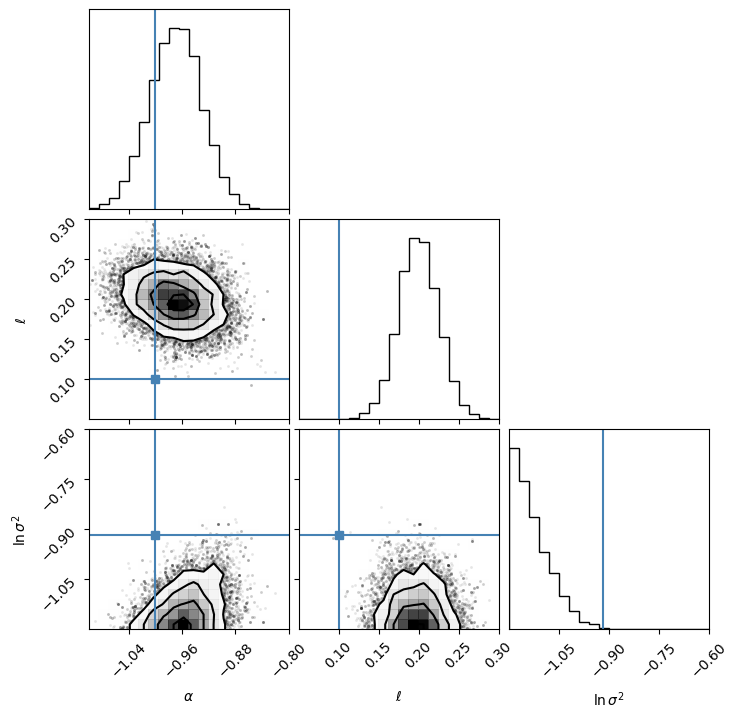

In [29]:
tri_cols = ["amp", "location", "log_sigma2"]
tri_labels = [r"$\alpha$", r"$\ell$", r"$\ln\sigma^2$"]
tri_truths = [truth[k] for k in tri_cols]
tri_range = [(-1.10, -0.8), (0.05, 0.3), (-1.2, -0.6)]
corner.corner(sampler.flatchain[:, 2:], 
              truths=tri_truths, 
              labels=tri_labels,
              range=tri_range);